In [89]:
import os
import numpy as np

folder_path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

subject_to_group = {subj: group for group, subjects in groups.items() for subj in subjects}

all_data = []

for filename in os.listdir(folder_path):
    if filename.endswith('_stages.npy'):
        # Estrai l'ID del soggetto rimuovendo 'EEG' se presente
        subject_part = filename.replace('_stages.npy', '')
        subject_id = subject_part.replace('EEG', '')  # es: 'PD003EEG' -> 'PD003'

        if subject_id in subject_to_group:
            group = subject_to_group[subject_id]
            full_path = os.path.join(folder_path, filename)
            scoring = np.load(full_path)
            all_data.append((subject_id, group, scoring))
            print(f"✅ {subject_id} ({group}) - scoring: {len(scoring)}")
        else:
            print(f"⚠️ {subject_id} non è in nessun gruppo definito.")

print(f"\nTotale soggetti caricati: {len(all_data)}")


✅ PD002 (ADV) - scoring: 869
✅ PD003 (ADV) - scoring: 1094
✅ PD005 (DNV) - scoring: 883
✅ PD007 (ADV) - scoring: 1173
✅ PD008 (ADV) - scoring: 1038
✅ PD009 (CTL) - scoring: 1000
✅ PD010 (CTL) - scoring: 837
✅ PD012 (DYS) - scoring: 871
✅ PD013 (DNV) - scoring: 971
✅ PD014 (DYS) - scoring: 967
✅ PD016 (DYS) - scoring: 958
✅ PD017 (DYS) - scoring: 1053
✅ PD020 (CTL) - scoring: 897
✅ PD021 (ADV) - scoring: 783
✅ PD022 (CTL) - scoring: 894
✅ PD025 (CTL) - scoring: 670
✅ PD027 (DNV) - scoring: 1029
✅ PD028 (ADV) - scoring: 952
✅ PD029 (DYS) - scoring: 977
✅ PD030 (DYS) - scoring: 832
✅ PD031 (DNV) - scoring: 877
✅ PD033 (CTL) - scoring: 896
✅ PD035 (DYS) - scoring: 998
✅ PD036 (ADV) - scoring: 1027
✅ PD038 (DYS) - scoring: 968
✅ PD041 (DNV) - scoring: 910
✅ PD042 (ADV) - scoring: 998
✅ PD043 (CTL) - scoring: 912
✅ PD044 (DYS) - scoring: 1030
✅ PD045 (DYS) - scoring: 759

Totale soggetti caricati: 30


In [90]:
import pandas as pd
import numpy as np

# Definizione delle fasi
sleep_values = [1, 2, 3, 5]  # N1, N2, N3, REM
scoring_data = []

for subject_id, group, scoring in all_data:
    scoring = scoring.astype(int)
    total_epochs = len(scoring)
    total_minutes = total_epochs * 0.5

    tst_epochs = np.isin(scoring, sleep_values).sum()
    tst_minutes = tst_epochs * 0.5

    se = tst_minutes / total_minutes * 100

    # Sleep Latency
    sleep_found = np.isin(scoring, sleep_values)
    if np.any(sleep_found):
        sl_epochs = np.argmax(sleep_found)
        sl_minutes = sl_epochs * 0.5
    else:
        sl_minutes = np.nan

    # SWS (N3)
    sws_minutes = (scoring == 3).sum() * 0.5

    # WASO
    if np.any(sleep_found):
        sleep_onset_idx = np.argmax(sleep_found)
        waso_epochs = np.sum(scoring[sleep_onset_idx+1:] == 0)
        waso_minutes = waso_epochs * 0.5
    else:
        waso_minutes = np.nan

    # WAKE (percentuale di epoche in cui si è svegli)
    wake_epochs = (scoring == 0).sum()  # Epoche di sveglio (0)
    wake_percent = wake_epochs / total_epochs * 100

    # REM (percentuale di epoche in fase REM)
    rem_epochs = (scoring == 5).sum()  # Epoche in REM (5)
    rem_percent = rem_epochs / total_epochs * 100

    scoring_data.append({
        "Subject": subject_id,
        "Group": group,
        "SE (%)": se,
        "SL (min)": sl_minutes,
        "SWS (min)": sws_minutes,
        "TST (min)": tst_minutes,
        "WASO (min)": waso_minutes,
        "WAKE (%)": wake_percent,
        "REM (%)": rem_percent
    })

# Creazione del DataFrame
df = pd.DataFrame(scoring_data)

# Seleziona solo le colonne numeriche
metrics_cols = ["SE (%)", "SL (min)", "SWS (min)", "TST (min)", "WASO (min)", "WAKE (%)", "REM (%)"]

# Calcolo media e std per gruppo
group_stats = df.groupby("Group")[metrics_cols].agg(['mean', 'std'])

# Trasposizione per avere gruppi sulle colonne
group_stats_T = group_stats.T

# Ordina le colonne come richiesto
ordered_groups = ["CTL", "DNV", "ADV", "DYS"]
group_stats_T = group_stats_T[ordered_groups]

# Visualizzazione finale (con valori arrotondati a 2 decimali)
group_stats_T.round(2)


Group               CTL     DNV     ADV     DYS
SE (%)     mean   70.40   75.13   66.58   62.40
           std    17.65    7.36    8.26   15.12
SL (min)   mean   32.86   29.90   28.06   13.00
           std    38.41   18.94   25.16   11.88
SWS (min)  mean   50.86   80.10   64.56   59.10
           std    13.10   60.34   46.26   50.68
TST (min)  mean  303.00  349.50  329.38  296.55
           std    65.59   24.26   49.19   88.65
WASO (min) mean   99.43   84.50  133.00  154.85
           std    76.38   32.52   47.88   65.34
WAKE (%)   mean   29.40   24.23   32.11   36.31
           std    17.56    7.08    7.81   15.36
REM (%)    mean   10.96   18.75   13.70    7.39
           std     7.28    6.20    7.25    6.30

In [91]:
from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Levene" if levene_p < 0.05 else "Bartlett"
            var_p = levene_p if levene_p < 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Fligner-Killeen"

        if all_normal:
            if var_p > 0.05:
                stat, p = f_oneway(*values_by_group)
                test_used = "ANOVA"
            else:
                stat, p = f_oneway(*values_by_group)
                test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}",
            "Var Test": var_test,
            "Var p": f"{var_p:.2e}",
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)



      Feature            Test   Stat   p-value         Var Test     Var p  \
0      SE (%)  Kruskal-Wallis  3.474  3.24e-01  Fligner-Killeen  5.96e-02   
1    SL (min)   Welch's ANOVA  1.116  3.61e-01         Bartlett  2.57e-02   
2   SWS (min)   Welch's ANOVA  0.427  7.36e-01         Bartlett  2.07e-02   
3   TST (min)           ANOVA  0.898  4.55e-01         Bartlett  7.25e-02   
4  WASO (min)           ANOVA  2.052  1.31e-01         Bartlett  3.32e-01   
5    WAKE (%)  Kruskal-Wallis  3.147  3.70e-01  Fligner-Killeen  4.72e-02   
6     REM (%)           ANOVA  3.400  3.26e-02         Bartlett  9.67e-01   

   CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  DYS Mean  DYS Std  
0     70.40    17.65     75.13     7.36     66.58     8.26     62.40    15.12  
1     32.86    38.41     29.90    18.94     28.06    25.16     13.00    11.88  
2     50.86    13.10     80.10    60.34     64.56    46.26     59.10    50.68  
3    303.00    65.59    349.50    24.26    329.38    49.19    2

In [92]:
import numpy as np
import os

# Percorso della cartella con i file
path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

# Funzione per caricare i dati
def load_data(path):
    # Lista di tutti i file nella cartella
    files = os.listdir(path)
    
    # Inizializzo i dizionari per stages e arousals
    all_data = []  # Dati delle fasi del sonno
    arousals_data = []  # Dati degli arousals

    # Carico i dati per ciascun paziente
    for file in files:
        if file.endswith("_stages.npy"):  # Stai cercando i file delle fasi del sonno
            subject_id = file.split('_')[0]  # Es. "PD003"
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            stages = np.load(os.path.join(path, file))  # Carica il file delle fasi del sonno
            all_data.append((subject_id, stages))
        
        if file.endswith("_arousals.npy"):  # Stai cercando i file degli arousals
            subject_id = file.split('_')[0]
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            arousals = np.load(os.path.join(path, file))  # Carica il file degli arousals
            arousals_data.append(arousals)

    return all_data, arousals_data

# Carica i dati
all_data, arousals_data = load_data(path)

# Verifica se la lunghezza dei dati è coerente
assert len(all_data) == len(arousals_data), "I dati delle fasi del sonno e degli arousals non corrispondono per ogni paziente!"

# Crea un dizionario per memorizzare le fasi del sonno senza arousals
subject_clean_stages = {}

# Sovrapponi i dati e determina gli arousals per ogni fase del sonno
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    # Trova gli indici degli arousals
    arousals_indices = np.where(arousals == 1)[0]
    arousals_stages = stages[arousals_indices]

    # Rimuovere gli arousals dai dati delle fasi del sonno
    non_arousal_mask = arousals != 1  # Maschera booleana: True dove NON ci sono arousals
    clean_stages = stages[non_arousal_mask]
    clean_arousals = arousals[non_arousal_mask]  # Dovrebbe essere tutto 0

    # Memorizza i clean stages nel dizionario
    subject_clean_stages[subject_id] = clean_stages

    # Stampa i risultati per ogni soggetto
    print(f"Subject: {subject_id}")
    print(f"Original length: {len(stages)}")
    print(f"Arousals removed: {np.sum(arousals)}")
    print(f"Cleaned length: {len(clean_stages)}")
    print(f"Cleaned stages preview: {clean_stages[:10]}")
    print("-" * 40)

for (subject_id, stages), arousals in zip(all_data, arousals_data):
    non_arousal_mask = arousals != 1  # Maschera per escludere gli arousals
    clean_stages = stages[non_arousal_mask]
    subject_clean_stages[subject_id] = clean_stages

# Verifica
print(f"Subjects with clean stages: {list(subject_clean_stages.keys())}")

Subject: PD002
Original length: 869
Arousals removed: 39
Cleaned length: 830
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD003
Original length: 1094
Arousals removed: 96
Cleaned length: 998
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD005
Original length: 883
Arousals removed: 72
Cleaned length: 811
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD007
Original length: 1173
Arousals removed: 178
Cleaned length: 995
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD008
Original length: 1038
Arousals removed: 71
Cleaned length: 967
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: PD009
Original length: 1000
Arousals removed: 139
Cleaned length: 861
Cleaned stages preview: [0 0 0 0 0 0 0 0 0 0]
----------------------------------------
Subject: P

In [104]:
import numpy as np
import os
import pandas as pd

# Percorso della cartella con i file
path = r"C:\Users\Lorenzo\Desktop\sleep_stages_09_12\clinical_annotations"

# Funzione per caricare i dati
def load_data(path):
    # Lista di tutti i file nella cartella
    files = os.listdir(path)
    
    # Inizializzo i dizionari per stages e arousals
    all_data = []  # Dati delle fasi del sonno
    arousals_data = []  # Dati degli arousals

    # Carico i dati per ciascun paziente
    for file in files:
        if  file.endswith("_stages.npy"):  # Stai cercando i file delle fasi del sonno
            subject_id = file.split('_')[0]  # Es. "PD003"
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            stages = np.load(os.path.join(path, file))  # Carica il file delle fasi del sonno
            all_data.append((subject_id, stages))
        
        if  file.endswith("_arousals.npy"):  # Stai cercando i file degli arousals
            subject_id = file.split('_')[0]
            subject_id = subject_id.replace('EEG', '')  # Rimuovi "EEG" dal subject_id
            arousals = np.load(os.path.join(path, file))  # Carica il file degli arousals
            arousals_data.append(arousals)

    return all_data, arousals_data

# Carica i dati
all_data, arousals_data = load_data(path)

# Verifica se la lunghezza dei dati è coerente
assert len(all_data) == len(arousals_data), "I dati delle fasi del sonno e degli arousals non corrispondono per ogni paziente!"

# Definizione delle fasi del sonno
sleep_values = [1, 2, 3, 5]  # N1, N2, N3, REM

# Definizione dei gruppi
groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

scoring_data = []

# Sovrapponi i dati e determina gli arousals per ogni fase del sonno
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_indices = np.where(arousals == 1)[0]  # Trova gli indici degli arousals
    non_arousal_mask = arousals != 1  # Maschera booleana: True dove NON ci sono arousals
    clean_stages = stages[non_arousal_mask]  # Applichiamo la maschera
    total_epochs = len(clean_stages)
    total_minutes = total_epochs * 0.5

    tst_epochs = np.isin(clean_stages, sleep_values).sum()
    tst_minutes = tst_epochs * 0.5

    se = tst_minutes / total_minutes * 100

    # Sleep Latency
    sleep_found = np.isin(clean_stages, sleep_values)
    if np.any(sleep_found):
        sl_epochs = np.argmax(sleep_found)
        sl_minutes = sl_epochs * 0.5
    else:
        sl_minutes = np.nan

    # SWS (N3)
    sws_minutes = (clean_stages == 3).sum() * 0.5

    # WASO
    if np.any(sleep_found):
        sleep_onset_idx = np.argmax(sleep_found)
        waso_epochs = np.sum(clean_stages[sleep_onset_idx+1:] == 0)
        waso_minutes = waso_epochs * 0.5
    else:
        waso_minutes = np.nan

    # WAKE (percentuale di epoche in cui si è svegli)
    wake_epochs = (clean_stages == 0).sum()  # Epoche di sveglio (0)
    wake_percent = wake_epochs / total_epochs * 100

    # REM (percentuale di epoche in fase REM)
    rem_epochs = (clean_stages == 5).sum()  # Epoche in REM (5)
    rem_percent = rem_epochs / total_epochs * 100

    # Aggiungi i dati del paziente e il gruppo
    group = next((group_name for group_name, subjects in groups.items() if subject_id in subjects), "Unknown")
    scoring_data.append({
        "Subject": subject_id,
        "Group": group,
        "SE (%)": se,
        "SL (min)": sl_minutes,
        "SWS (min)": sws_minutes,
        "TST (min)": tst_minutes,
        "WASO (min)": waso_minutes,
        "WAKE (%)": wake_percent,
        "REM (%)": rem_percent
    })

# Creazione del DataFrame
df = pd.DataFrame(scoring_data)

# Seleziona solo le colonne numeriche
metrics_cols = ["SE (%)", "SL (min)", "SWS (min)", "TST (min)", "WASO (min)", "WAKE (%)", "REM (%)"]

# Calcolo media e std per gruppo
group_stats = df.groupby("Group")[metrics_cols].agg(['mean', 'std'])

# Trasposizione per avere i gruppi sulle colonne
group_stats_T = group_stats.T

# Ordina le colonne come richiesto
ordered_groups = ["CTL", "DNV", "ADV", "DYS"]
group_stats_T = group_stats_T[ordered_groups]

from scipy.stats import shapiro, levene, bartlett, fligner, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

def compute_statistical_summary(df, metrics_cols):
    summary = []

    for feature in metrics_cols:
        values_by_group = [df[df["Group"] == g][feature].dropna() for g in ordered_groups]

        # ✅ Test di normalità con Shapiro-Wilk
        group_normality = {g: shapiro(data)[1] if len(data) >= 3 else np.nan  # evita errori con gruppi piccolissimi
                           for g, data in zip(ordered_groups, values_by_group)}
        all_normal = all(p > 0.05 for p in group_normality.values() if not np.isnan(p))

        if all_normal:
            levene_p = levene(*values_by_group)[1]
            bartlett_p = bartlett(*values_by_group)[1]
            var_test = "Levene" if levene_p < 0.05 else "Bartlett"
            var_p = levene_p if levene_p < 0.05 else bartlett_p
        else:
            var_p = fligner(*values_by_group)[1]
            var_test = "Fligner-Killeen"

        if all_normal:
            if var_p > 0.05:
                stat, p = f_oneway(*values_by_group)
                test_used = "ANOVA"
            else:
                stat, p = f_oneway(*values_by_group)
                test_used = "Welch's ANOVA"
        else:
            stat, p = kruskal(*values_by_group)
            test_used = "Kruskal-Wallis"

        # Calcolo media e std per ogni gruppo
        means = df.groupby("Group")[feature].mean().reindex(ordered_groups).round(2).to_dict()
        stds = df.groupby("Group")[feature].std().reindex(ordered_groups).round(2).to_dict()

        row = {
            "Feature": feature,
            "Test": test_used,
            "Stat": round(stat, 3),
            "p-value": f"{p:.2e}",
            "Var Test": var_test,
            "Var p": f"{var_p:.2e}",
        }

        # Aggiungi media e std per ogni gruppo
        for g in ordered_groups:
            row[f"{g} Mean"] = means[g]
            row[f"{g} Std"] = stds[g]

        summary.append(row)

    return pd.DataFrame(summary)

stats_summary_df = compute_statistical_summary(df, metrics_cols)

# Mostra il risultato
pd.set_option('display.max_columns', None)
print(stats_summary_df)




      Feature            Test   Stat   p-value         Var Test     Var p  \
0      SE (%)  Kruskal-Wallis  3.564  3.13e-01  Fligner-Killeen  1.87e-01   
1    SL (min)  Kruskal-Wallis  3.572  3.12e-01  Fligner-Killeen  2.52e-01   
2   SWS (min)   Welch's ANOVA  0.402  7.53e-01         Bartlett  2.16e-02   
3   TST (min)  Kruskal-Wallis  5.162  1.60e-01  Fligner-Killeen  3.13e-01   
4  WASO (min)           ANOVA  2.086  1.26e-01         Bartlett  3.39e-01   
5    WAKE (%)  Kruskal-Wallis  3.211  3.60e-01  Fligner-Killeen  1.01e-01   
6     REM (%)           ANOVA  2.809  5.93e-02         Bartlett  9.66e-01   

   CTL Mean  CTL Std  DNV Mean  DNV Std  ADV Mean  ADV Std  DYS Mean  DYS Std  
0     68.96    19.17     74.24     9.51     64.85     9.27     59.58    16.39  
1     35.00    43.48     30.20    18.56     28.38    25.06     13.15    11.92  
2     49.93    12.79     77.60    57.82     63.06    45.90     57.70    49.53  
3    257.43    58.06    308.20    39.49    292.50    55.59    2

FINE VARIABILI 
------------------------------------
------------------------------------
------------------------------------


N3 normalizzato su tutte le epoche N3 

"Dove si concentra il sonno profondo" lungo il periodo NREM.

Ti dice se un soggetto o gruppo tende ad avere più N3 all'inizio o alla fine della notte.

È una distribuzione relativa del sonno profondo.


Distribuzione media % di N3 (su totale N3) per segmento, per gruppo:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       9.57      16.45      14.68      16.52       7.94       5.44   
DNV       5.75      18.09      12.42      19.34       6.32       5.55   
ADV      10.88      27.48       7.51      13.97      14.86       4.43   
DYS      12.04      15.97      13.93      10.34       2.52      19.20   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       7.19       4.94       3.45       13.83  
DNV      14.72       9.75       2.34        5.72  
ADV       4.99       3.50       1.63       10.76  
DYS       5.57       6.20       3.66        0.57  


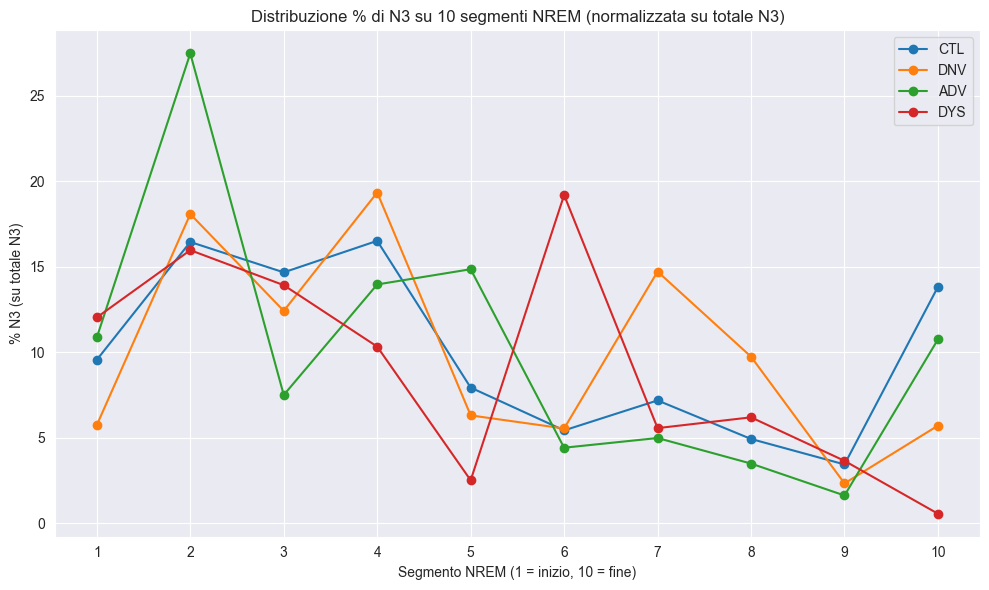

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inizializza la struttura per salvare i profili N3 per gruppo
group_n3_profiles = {group: [] for group in groups.keys()}
group_n3_profiles["Unknown"] = []  # In caso di soggetti non classificati

# Loop per ogni soggetto
for subject_id, stages in all_data:
    # Maschera per NREM (N1=1, N2=2, N3=3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    # Se la sequenza NREM è troppo corta, si può eventualmente saltare
    if len(nrem_stages) < 10:
        continue

    # Divide in 10 segmenti uguali
    segment_length = len(nrem_stages) // 10
    n3_counts = []

    for i in range(10):
        start = i * segment_length
        # L’ultimo segmento prende tutto quello che resta
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_count = np.sum(segment == 3)
        n3_counts.append(n3_count)

    # Normalizza in percentuale sul totale N3 del soggetto
    total_n3 = sum(n3_counts)
    if total_n3 > 0:
        n3_profile = [count / total_n3 * 100 for count in n3_counts]
    else:
        n3_profile = [0] * 10

    # Salva nel gruppo corretto
    group = next((group_name for group_name, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles[group].append(n3_profile)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_profiles.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long = pd.DataFrame(rows)


# Calcolo della media per ciascun gruppo
group_n3_avg_profiles = {}
for group, profiles in group_n3_profiles.items():
    if profiles:  # Se il gruppo ha almeno un soggetto
        mean_profile = np.mean(profiles, axis=0)
        group_n3_avg_profiles[group] = mean_profile

# Crea il DataFrame finale con righe = gruppi, colonne = segmenti
df_n3_distribution = pd.DataFrame(
    group_n3_avg_profiles,
    index=[f"Segment_{i+1}" for i in range(10)]
).T  # Transpose: gruppi su righe, segmenti su colonne

# Stampa il DataFrame
print("\nDistribuzione media % di N3 (su totale N3) per segmento, per gruppo:")
print(df_n3_distribution.round(2))

# Plot
plt.figure(figsize=(10, 6))
x = range(1, 11)

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles:
        plt.plot(x, group_n3_avg_profiles[group], marker='o', label=group)

plt.title("Distribuzione % di N3 su 10 segmenti NREM (normalizzata su totale N3)")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 (su totale N3)")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
from scipy.stats import ttest_ind, mannwhitneyu

# --- Calcolo Early vs Late per ciascun soggetto ---
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

df_long["Early"] = df_long[early_segments].mean(axis=1)
df_long["Late"] = df_long[late_segments].mean(axis=1)


results = []

for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long[df_long["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]
    
    # Escludi gruppi troppo piccoli
    if len(early) < 3 or len(late) < 3:
        continue

    # Test di normalità separato per Early e Late
    p_shapiro_early = shapiro(early)[1]
    p_shapiro_late = shapiro(late)[1]
    normal_early = p_shapiro_early > 0.05
    normal_late = p_shapiro_late > 0.05

    if normal_early and normal_late:
        stat, pval = ttest_ind(early, late)
        test = "Independent t-test"
    else:
        stat, pval = mannwhitneyu(early, late)
        test = "Mann-Whitney U"

    # Determina se rifiutare o meno l'ipotesi nulla
    reject_null = pval < 0.05  # Se il p-value è minore di 0.05, rifiuti l'ipotesi nulla

    results.append({
        "Group": group,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.2e}",
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Reject H₀": "Yes" if reject_null else "No"  # Aggiungi la colonna con il risultato dell'ipotesi nulla
    })

df_early_late_stats = pd.DataFrame(results)
print("\n📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:")
print(df_early_late_stats)



📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:
  Group                Test    Stat   p-value  Early Mean  Late Mean Reject H₀
0   CTL  Independent t-test   4.444  8.01e-04       15.88       5.19       Yes
1   DNV      Mann-Whitney U  21.000  9.52e-02       16.62       8.94        No
2   ADV  Independent t-test   4.515  4.85e-04       16.32       3.37       Yes
3   DYS  Independent t-test   2.437  2.54e-02       13.41       5.14       Yes



▶ Distribuzione media % di N3 (su totale N3) per segmento [SENZA AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       8.37      16.72      17.10      12.85       8.94       6.41   
DNV       8.16      15.97      13.26      18.92       6.28       7.36   
ADV      11.47      27.08      10.95       8.57      16.27       4.72   
DYS      11.10      16.63      13.71       9.93       4.65      17.38   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       7.20       4.85       4.78       12.79  
DNV      12.20       9.25       2.74        5.87  
ADV       5.72       2.90       2.22       10.10  
DYS       6.17       4.46       5.48        0.48  


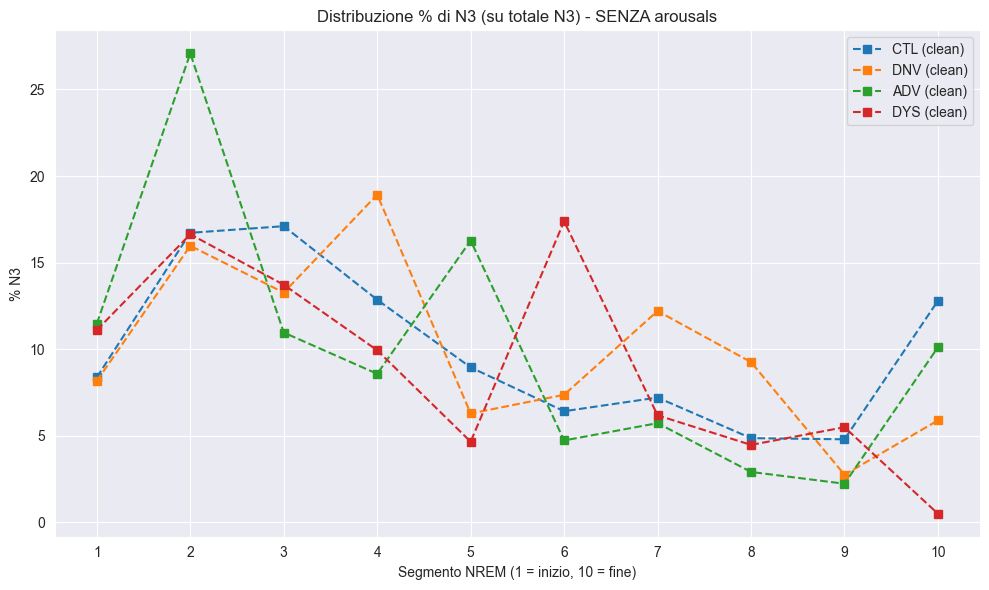

In [129]:
# --- SENZA AROUSALS ---

group_n3_profiles_clean = {group: [] for group in groups.keys()}
group_n3_profiles_clean["Unknown"] = []

for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_mask = arousals != 1
    clean_stages = stages[arousals_mask]

    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    if len(nrem_stages) < 10:
        continue
        
    segment_length = len(nrem_stages) // 10
    n3_counts = []

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        n3_counts.append(np.sum(segment == 3))

    total_n3 = sum(n3_counts)
    n3_profile = [count / total_n3 * 100 if total_n3 > 0 else 0 for count in n3_counts]

    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_profiles_clean[group].append(n3_profile)
    
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_profiles_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_clean = pd.DataFrame(rows)

# Media per gruppo
group_n3_avg_profiles_clean = {
    group: np.mean(profiles, axis=0)
    for group, profiles in group_n3_profiles_clean.items()
    if profiles
}

# DataFrame
df_n3_distribution_clean = pd.DataFrame(
    group_n3_avg_profiles_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

print("\n▶ Distribuzione media % di N3 (su totale N3) per segmento [SENZA AROUSALS]:")
print(df_n3_distribution_clean.round(2))

# Plot
plt.figure(figsize=(10, 6))
for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_profiles_clean:
        plt.plot(x, group_n3_avg_profiles_clean[group], marker='s', linestyle='--', label=f"{group} (clean)")

plt.title("Distribuzione % di N3 (su totale N3) - SENZA arousals")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
from scipy.stats import ttest_ind, mannwhitneyu

# Early and late segments definition
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]
#early_segments = ["Segment_1", "Segment_2", "Segment_3", "Segment_4"]
# = ["Segment_7", "Segment_8", "Segment_9", "Segment_10"]

df_long_clean["Early"] = df_long_clean[early_segments].mean(axis=1)
df_long_clean["Late"] = df_long_clean[late_segments].mean(axis=1)


results = []

for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_clean[df_long_clean["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]
    
    # Escludi gruppi troppo piccoli
    if len(early) < 3 or len(late) < 3:
        continue

    # Test di normalità separato per Early e Late
    p_shapiro_early = shapiro(early)[1]
    p_shapiro_late = shapiro(late)[1]
    normal_early = p_shapiro_early > 0.05
    normal_late = p_shapiro_late > 0.05

    if normal_early and normal_late:
        stat, pval = ttest_ind(early, late)
        test = "Independent t-test"
    else:
        stat, pval = mannwhitneyu(early, late)
        test = "Mann-Whitney U"

    # Determina se rifiutare o meno l'ipotesi nulla
    reject_null = pval < 0.05  # Se il p-value è minore di 0.05, rifiuti l'ipotesi nulla

    results.append({
        "Group": group,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.2e}",
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Reject H₀": "Yes" if reject_null else "No"  # Aggiungi la colonna con il risultato dell'ipotesi nulla
    })

df_early_late_stats = pd.DataFrame(results)
print("\n📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:")
print(df_early_late_stats)



📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:
  Group                Test    Stat   p-value  Early Mean  Late Mean Reject H₀
0   CTL  Independent t-test   3.677  3.16e-03       15.56       5.61       Yes
1   DNV      Mann-Whitney U  21.000  9.52e-02       16.05       8.06        No
2   ADV  Independent t-test   4.858  2.53e-04       15.54       3.61       Yes
3   DYS  Independent t-test   2.618  1.74e-02       13.43       5.37       Yes



▶ Media dei minuti in N3 per segmento [SENZA AROUSALS]:
     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL       4.50       8.43       9.79       6.71       3.29       3.29   
DNV       7.90      12.10      11.40      10.90       7.60       6.30   
ADV       7.75      12.00       6.88       5.44       9.56       4.94   
DYS       8.65      11.65      10.30       7.65       2.90       6.40   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL       3.36       2.79       1.71        6.07  
DNV       6.30       8.60       3.20        3.30  
ADV       4.12       3.19       2.31        6.88  
DYS       3.30       2.25       4.40        0.20  


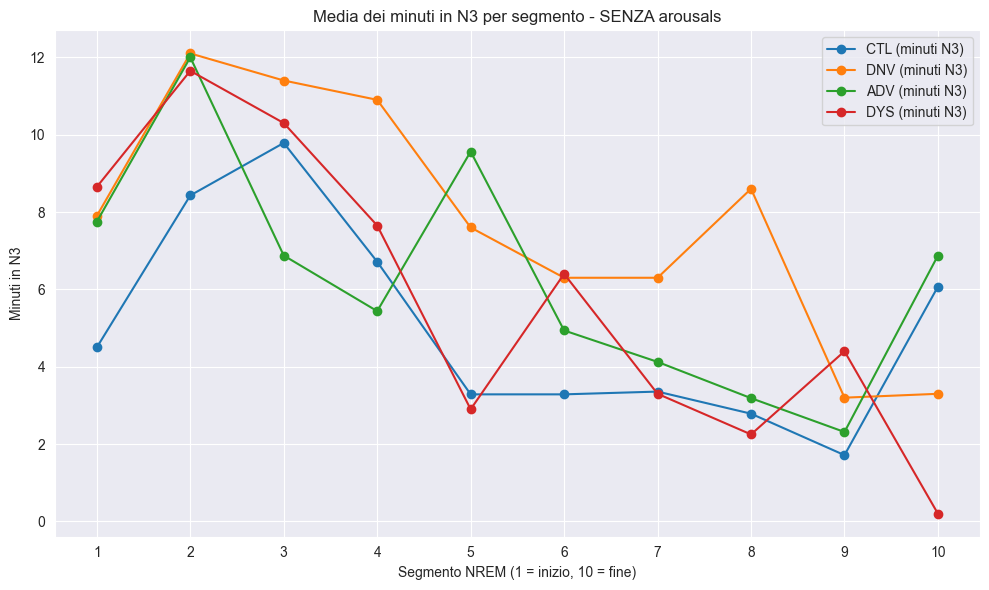

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- SENZA AROUSALS ---

group_n3_minutes_clean = {group: [] for group in groups.keys()}
group_n3_minutes_clean["Unknown"] = []

for (subject_id, stages), arousals in zip(all_data, arousals_data):
    arousals_mask = arousals != 1
    clean_stages = stages[arousals_mask]

    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    if len(nrem_stages) < 10:
        continue

    segment_length = len(nrem_stages) // 10
    n3_minutes = []  # Lista per memorizzare i minuti in N3 per ogni segmento

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]
        
        # Calcola il numero di N3 nel segmento
        n3_count = np.sum(segment == 3)
        
        # Aggiungi il numero di minuti in N3 per segmento (dove ogni epoca è di 30 secondi)
        n3_minutes.append(n3_count / 2)  # Dividi per 2 per ottenere i minuti


    # Media dei minuti in N3 per ogni segmento
    n3_minutes_avg = [minute for minute in n3_minutes]

    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_minutes_clean[group].append(n3_minutes_avg)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_minutes_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_min = pd.DataFrame(rows)

# Media per gruppo
group_n3_avg_minutes_clean = {
    group: np.mean(minutes, axis=0)
    for group, minutes in group_n3_minutes_clean.items()
    if minutes
}

# DataFrame per i minuti medi
df_n3_minutes_clean = pd.DataFrame(
    group_n3_avg_minutes_clean,
    index=[f"Segment_{i+1}" for i in range(10)]
).T

print("\n▶ Media dei minuti in N3 per segmento [SENZA AROUSALS]:")
print(df_n3_minutes_clean.round(2))

# Plot per i minuti in N3
x = np.arange(1, 11)
plt.figure(figsize=(10, 6))
for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_avg_minutes_clean:
        plt.plot(x, group_n3_avg_minutes_clean[group], marker='o', linestyle='-', label=f"{group} (minuti N3)")

plt.title("Media dei minuti in N3 per segmento - SENZA arousals")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("Minuti in N3")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [134]:
from scipy.stats import ttest_ind, mannwhitneyu

# --- Calcolo Early vs Late per ciascun soggetto ---
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

df_long_min["Early"] = df_long_min[early_segments].mean(axis=1)
df_long_min["Late"] = df_long_min[late_segments].mean(axis=1)


results = []

for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_min[df_long_min["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Test di normalità separato per Early e Late
    p_shapiro_early = shapiro(early)[1]
    p_shapiro_late = shapiro(late)[1]
    normal_early = p_shapiro_early > 0.05
    normal_late = p_shapiro_late > 0.05

    if normal_early and normal_late:
        stat, pval = ttest_ind(early, late)
        test = "Independent t-test"
    else:
        stat, pval = mannwhitneyu(early, late)
        test = "Mann-Whitney U"

    # Determina se rifiutare o meno l'ipotesi nulla
    reject_null = pval < 0.05  # Se il p-value è minore di 0.05, rifiuti l'ipotesi nulla

    results.append({
        "Group": group,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.2e}",
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Reject H₀": "Yes" if reject_null else "No"  # Aggiungi la colonna con il risultato dell'ipotesi nulla
    })

df_early_late_stats = pd.DataFrame(results)
print("\n📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:")
print(df_early_late_stats)



📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:
  Group                Test    Stat   p-value  Early Mean  Late Mean Reject H₀
0   CTL  Independent t-test   3.020  1.07e-02        8.31       2.62       Yes
1   DNV  Independent t-test   1.412  1.96e-01       11.47       6.03        No
2   ADV      Mann-Whitney U  50.000  6.57e-02        8.10       3.21        No
3   DYS  Independent t-test   2.024  5.81e-02        9.87       3.32        No


N3 normalizzato su epoche NREM totali per segmentoN3 normalizzato su epoche NREM totali per segmento

N3 / [N1+N2+N3]

"Quanto NREM è N3?" → misura la qualità del sonno NREM in ogni parte della notte.



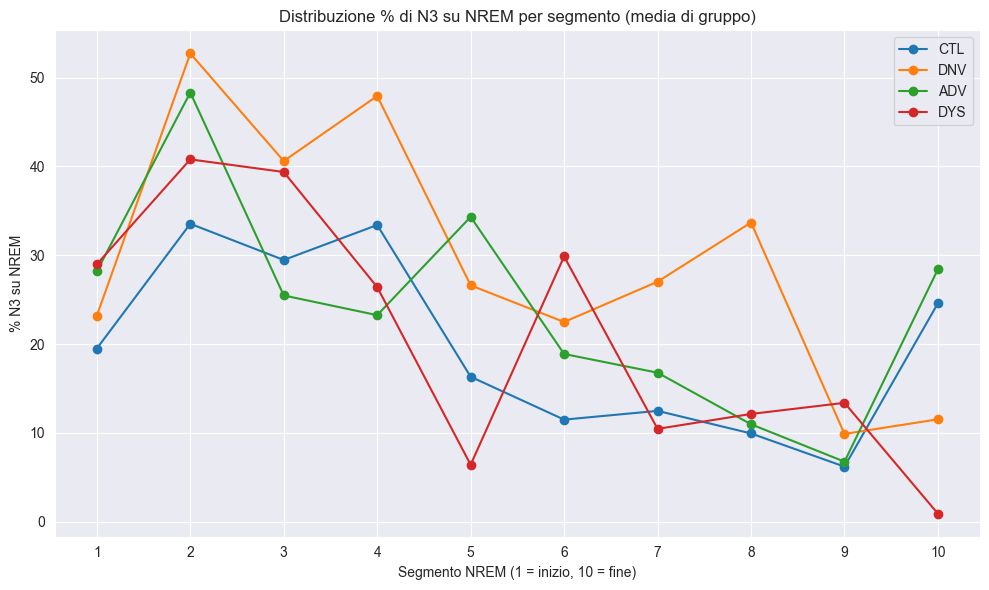


Percentuale media di N3 su NREM per segmento e per gruppo:

     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL      19.50      33.54      29.47      33.40      16.32      11.49   
DNV      23.19      52.73      40.61      47.93      26.61      22.48   
ADV      28.19      48.33      25.47      23.25      34.32      18.88   
DYS      28.98      40.79      39.37      26.41       6.41      29.86   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL      12.48       9.93       6.19       24.59  
DNV      27.02      33.69       9.88       11.52  
ADV      16.78      10.97       6.75       28.43  
DYS      10.45      12.13      13.38        0.89  


In [121]:
import matplotlib.pyplot as plt

# Inizializza il dizionario per salvare i profili normalizzati N3/NREM
group_n3_norm_profiles = {group: [] for group in groups.keys()}
group_n3_norm_profiles["Unknown"] = []

# Calcolo per ogni soggetto
for subject_id, stages in all_data:
    # Maschera per NREM (1, 2, 3)
    nrem_mask = np.isin(stages, [1, 2, 3])
    nrem_stages = stages[nrem_mask]

    if len(nrem_stages) < 10:
        continue

    segment_length = len(nrem_stages) // 10
    segment_n3_ratios = []

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]

        n3_count = np.sum(segment == 3)
        nrem_count = len(segment)
        ratio = (n3_count / nrem_count * 100) if nrem_count > 0 else 0
        segment_n3_ratios.append(ratio)

    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_norm_profiles[group].append(segment_n3_ratios)
    
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_norm_profiles.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_norm = pd.DataFrame(rows)

# Calcola la media per gruppo
group_n3_segment_avg = {}
for group, profiles in group_n3_norm_profiles.items():
    if profiles:
        group_n3_segment_avg[group] = np.mean(profiles, axis=0)

# Plot
plt.figure(figsize=(10, 6))
x = range(1, 11)

for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_segment_avg:
        plt.plot(x, group_n3_segment_avg[group], marker='o', label=group)

plt.title("Distribuzione % di N3 su NREM per segmento (media di gruppo)")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 su NREM")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Creazione del DataFrame con i dati medi per gruppo
df_n3_segment = pd.DataFrame(group_n3_segment_avg, index=[f"Segment_{i+1}" for i in range(10)])

# Trasponi per avere i gruppi sulle righe (opzionale, ma più leggibile)
df_n3_segment = df_n3_segment.T

# Mostra il DataFrame arrotondato a 2 decimali
print("\nPercentuale media di N3 su NREM per segmento e per gruppo:\n")
print(df_n3_segment.round(2))



In [122]:
from scipy.stats import ttest_ind, mannwhitneyu

# --- Calcolo Early vs Late per ciascun soggetto ---
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

df_long_norm["Early"] = df_long_norm[early_segments].mean(axis=1)
df_long_norm["Late"] = df_long_norm[late_segments].mean(axis=1)


results = []

for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_norm[df_long_norm["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Test di normalità separato per Early e Late
    p_shapiro_early = shapiro(early)[1]
    p_shapiro_late = shapiro(late)[1]
    normal_early = p_shapiro_early > 0.05
    normal_late = p_shapiro_late > 0.05

    if normal_early and normal_late:
        stat, pval = ttest_ind(early, late)
        test = "Independent t-test"
    else:
        stat, pval = mannwhitneyu(early, late)
        test = "Mann-Whitney U"

    # Determina se rifiutare o meno l'ipotesi nulla
    reject_null = pval < 0.05  # Se il p-value è minore di 0.05, rifiuti l'ipotesi nulla

    results.append({
        "Group": group,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.2e}",
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Reject H₀": "Yes" if reject_null else "No"  # Aggiungi la colonna con il risultato dell'ipotesi nulla
    })

df_early_late_stats = pd.DataFrame(results)
print("\n📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:")
print(df_early_late_stats)



📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:
  Group                Test    Stat   p-value  Early Mean  Late Mean Reject H₀
0   CTL  Independent t-test   4.171  1.30e-03       32.14       9.53       Yes
1   DNV  Independent t-test   1.651  1.37e-01       47.09      23.53        No
2   ADV      Mann-Whitney U  52.000  4.04e-02       32.35      11.50       Yes
3   DYS      Mann-Whitney U  71.500  1.12e-01       35.53      11.99        No



▶ Percentuale media di N3 su NREM per segmento [SENZA AROUSALS]:

     Segment_1  Segment_2  Segment_3  Segment_4  Segment_5  Segment_6  \
CTL      20.73      41.14      43.67      31.52      19.73      14.97   
DNV      31.99      50.83      47.63      50.69      28.76      25.57   
ADV      31.86      51.55      28.98      22.21      37.05      19.23   
DYS      32.76      45.76      43.01      30.49      11.46      33.69   

     Segment_7  Segment_8  Segment_9  Segment_10  
CTL      13.41      12.21       9.80       26.71  
DNV      27.46      34.56      12.87       12.09  
ADV      17.91      11.35       9.00       30.02  
DYS      15.37      11.19      18.65        1.01  


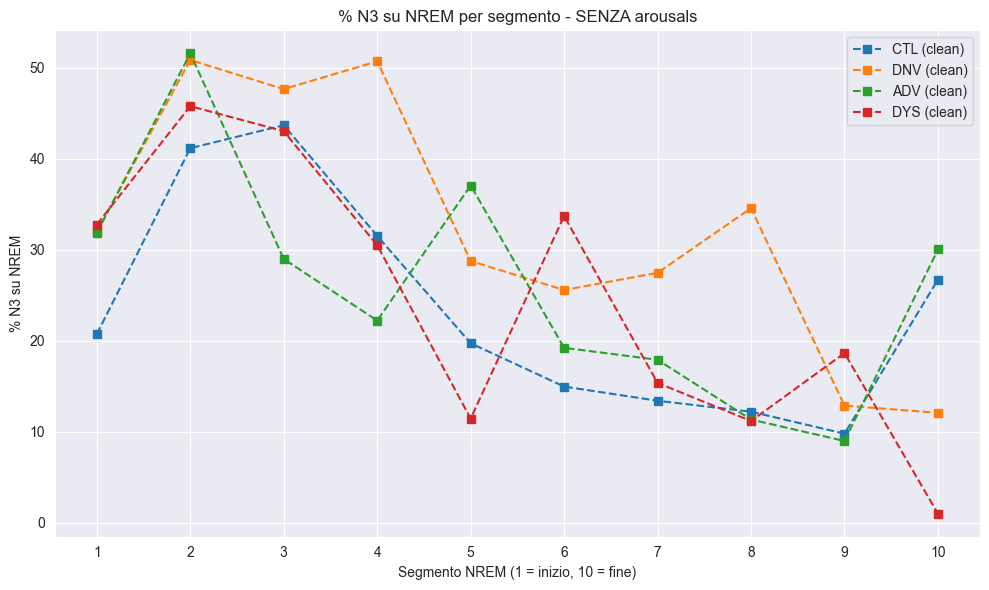

In [123]:
# --- SENZA AROUSALS ---
group_n3_norm_profiles_clean = {group: [] for group in groups.keys()}
group_n3_norm_profiles_clean["Unknown"] = []

for (subject_id, stages), arousals in zip(all_data, arousals_data):
    # Esclude arousals
    clean_stages = stages[arousals != 1]
    nrem_mask = np.isin(clean_stages, [1, 2, 3])
    nrem_stages = clean_stages[nrem_mask]

    if len(nrem_stages) < 10:
        continue

    segment_length = len(nrem_stages) // 10
    segment_n3_ratios = []

    for i in range(10):
        start = i * segment_length
        end = (i + 1) * segment_length if i < 9 else len(nrem_stages)
        segment = nrem_stages[start:end]

        n3_count = np.sum(segment == 3)
        ratio = (n3_count / len(segment)) * 100 if len(segment) > 0 else 0
        segment_n3_ratios.append(ratio)

    group = next((g for g, subjects in groups.items() if subject_id in subjects), "Unknown")
    group_n3_norm_profiles_clean[group].append(segment_n3_ratios)
rows = []

# Invertiamo groups per trovare soggetto → gruppo
subject_to_group = {}
for group, subject_ids in groups.items():
    for sid in subject_ids:
        subject_to_group[sid] = group

# Serve un contatore perché group_n3_profiles ha solo i profili, non gli ID
for group, profiles in group_n3_norm_profiles_clean.items():
    for idx, profile in enumerate(profiles):
        row = {
            "Group": group,
            "Subject_ID": f"{group}_{idx:02d}"  # inventiamo un ID univoco
        }
        for i, val in enumerate(profile):
            row[f"Segment_{i+1}"] = val
        rows.append(row)

df_long_norm_clean = pd.DataFrame(rows)

# Media per gruppo
group_n3_segment_avg_clean = {
    group: np.mean(profiles, axis=0)
    for group, profiles in group_n3_norm_profiles_clean.items()
    if profiles
}

# DataFrame
df_n3_segment_clean = pd.DataFrame(group_n3_segment_avg_clean, index=[f"Segment_{i+1}" for i in range(10)]).T

# Print
print("\n▶ Percentuale media di N3 su NREM per segmento [SENZA AROUSALS]:\n")
print(df_n3_segment_clean.round(2))

# Plot
plt.figure(figsize=(10, 6))
for group in ["CTL", "DNV", "ADV", "DYS"]:
    if group in group_n3_segment_avg_clean:
        plt.plot(x, group_n3_segment_avg_clean[group], marker='s', linestyle='--', label=f"{group} (clean)")

plt.title("% N3 su NREM per segmento - SENZA arousals")
plt.xlabel("Segmento NREM (1 = inizio, 10 = fine)")
plt.ylabel("% N3 su NREM")
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [124]:
from scipy.stats import ttest_ind, mannwhitneyu

# --- Calcolo Early vs Late per ciascun soggetto ---
early_segments = ["Segment_2", "Segment_3", "Segment_4"]
late_segments = ["Segment_7", "Segment_8", "Segment_9"]

df_long_norm_clean["Early"] = df_long_norm_clean[early_segments].mean(axis=1)
df_long_norm_clean["Late"] = df_long_norm_clean[late_segments].mean(axis=1)


results = []

for group in ["CTL", "DNV", "ADV", "DYS"]:
    df_group = df_long_norm_clean[df_long_norm_clean["Group"] == group]
    early = df_group["Early"]
    late = df_group["Late"]

    # Test di normalità separato per Early e Late
    p_shapiro_early = shapiro(early)[1]
    p_shapiro_late = shapiro(late)[1]
    normal_early = p_shapiro_early > 0.05
    normal_late = p_shapiro_late > 0.05

    if normal_early and normal_late:
        stat, pval = ttest_ind(early, late)
        test = "Independent t-test"
    else:
        stat, pval = mannwhitneyu(early, late)
        test = "Mann-Whitney U"

    # Determina se rifiutare o meno l'ipotesi nulla
    reject_null = pval < 0.05  # Se il p-value è minore di 0.05, rifiuti l'ipotesi nulla

    results.append({
        "Group": group,
        "Test": test,
        "Stat": round(stat, 3),
        "p-value": f"{pval:.2e}",
        "Early Mean": round(early.mean(), 2),
        "Late Mean": round(late.mean(), 2),
        "Reject H₀": "Yes" if reject_null else "No"  # Aggiungi la colonna con il risultato dell'ipotesi nulla
    })

df_early_late_stats = pd.DataFrame(results)
print("\n📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:")
print(df_early_late_stats)



📊 Confronto Early vs Late (segmenti 2–4 vs 7–9) per gruppo:
  Group                Test   Stat   p-value  Early Mean  Late Mean Reject H₀
0   CTL  Independent t-test  3.123  8.81e-03       38.78      11.81       Yes
1   DNV  Independent t-test  1.699  1.28e-01       49.71      24.96        No
2   ADV  Independent t-test  2.285  3.84e-02       34.25      12.75       Yes
3   DYS  Independent t-test  2.238  3.81e-02       39.75      15.07       Yes


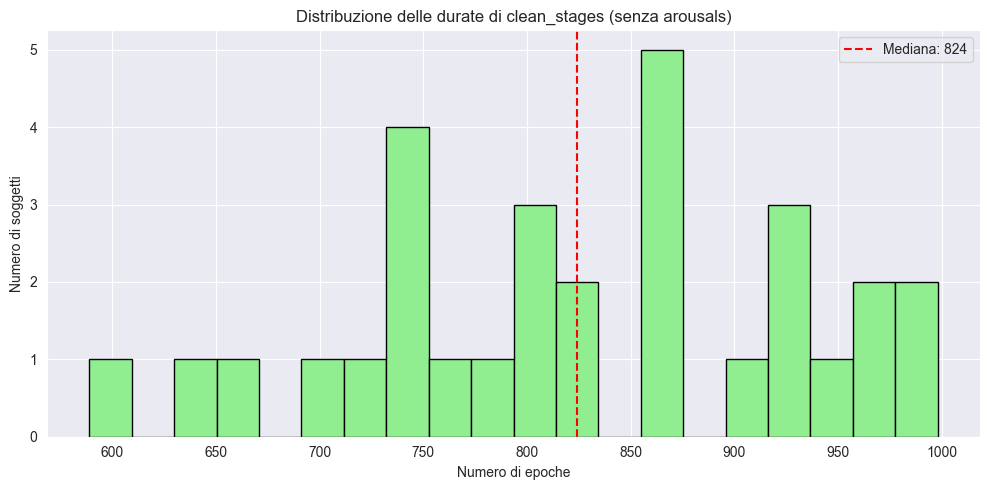


📊 Numero totale di soggetti: 30
▶ Durata mediana: 824 epoche
👤 Soggetto più vicino alla mediana: PD041 (819 epoche)


In [46]:
import matplotlib.pyplot as plt

# Lista per salvare subject_id e durata dei clean_stages
subject_durations = []

# Ricostruisco le durate dai dati già caricati
for (subject_id, stages), arousals in zip(all_data, arousals_data):
    non_arousal_mask = arousals != 1
    clean_stages = stages[non_arousal_mask]
    
    duration = len(clean_stages)
    subject_durations.append((subject_id, duration))

# Ordina le durate
subject_durations_sorted = sorted(subject_durations, key=lambda x: x[1])
durations_only = [d for _, d in subject_durations_sorted]

# Calcola la mediana
median_duration = int(np.median(durations_only))

# Trova il soggetto più vicino alla mediana
closest_subject = min(subject_durations_sorted, key=lambda x: abs(x[1] - median_duration))

# Plot della distribuzione
plt.figure(figsize=(10, 5))
plt.hist(durations_only, bins=20, color='lightgreen', edgecolor='black')
plt.axvline(median_duration, color='red', linestyle='--', label=f'Mediana: {median_duration}')
plt.title("Distribuzione delle durate di clean_stages (senza arousals)")
plt.xlabel("Numero di epoche")
plt.ylabel("Numero di soggetti")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output testuale
print(f"\n📊 Numero totale di soggetti: {len(subject_durations)}")
print(f"▶ Durata mediana: {median_duration} epoche")
print(f"👤 Soggetto più vicino alla mediana: {closest_subject[0]} ({closest_subject[1]} epoche)")



Applico DTW tra PD010 (riferimento) e PD002
DTW distance con PD002: 476.0


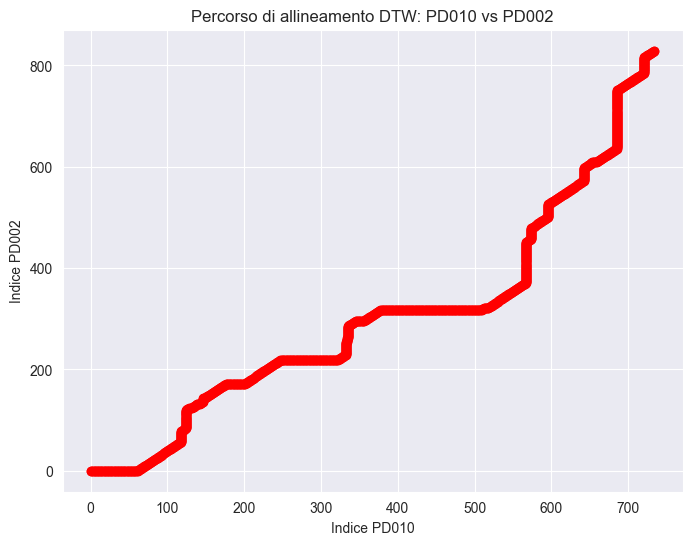

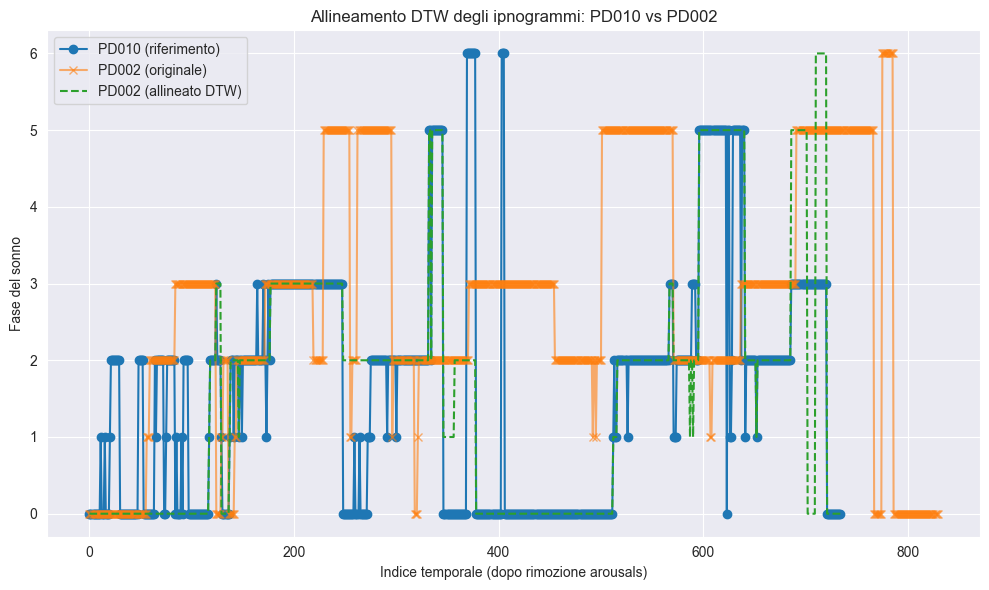


Applico DTW tra PD010 (riferimento) e PD003
DTW distance con PD003: 324.0

Applico DTW tra PD010 (riferimento) e PD005
DTW distance con PD005: 435.0

Applico DTW tra PD010 (riferimento) e PD007
DTW distance con PD007: 449.0

Applico DTW tra PD010 (riferimento) e PD008
DTW distance con PD008: 324.0

Applico DTW tra PD010 (riferimento) e PD009
DTW distance con PD009: 380.0

Applico DTW tra PD010 (riferimento) e PD012
DTW distance con PD012: 347.0

Applico DTW tra PD010 (riferimento) e PD013
DTW distance con PD013: 371.0

Applico DTW tra PD010 (riferimento) e PD014
DTW distance con PD014: 259.0

Applico DTW tra PD010 (riferimento) e PD016
DTW distance con PD016: 301.0

Applico DTW tra PD010 (riferimento) e PD017
DTW distance con PD017: 310.0

Applico DTW tra PD010 (riferimento) e PD020
DTW distance con PD020: 166.0

Applico DTW tra PD010 (riferimento) e PD021
DTW distance con PD021: 470.0

Applico DTW tra PD010 (riferimento) e PD022
DTW distance con PD022: 313.0

Applico DTW tra PD010 (r

In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
from dtw import dtw

# --- Imposta il soggetto di riferimento ---
reference_subject = 'PD010'
if reference_subject not in subject_clean_stages:
    raise ValueError(f"Il soggetto di riferimento {reference_subject} non è presente nei dati.")

ref_stages = subject_clean_stages[reference_subject]
aligned_stages_dict = {}  # Qui salveremo i dati allineati
aligned_stages_dict[reference_subject] = ref_stages  # Il soggetto di riferimento resta invariato


# --- Ciclo su tutti gli altri soggetti ---
first_plot_done = False  # Flag per tracciare se abbiamo già plottato

for subject_id, target_stages in subject_clean_stages.items():
    if subject_id == reference_subject:
        continue  # Salta il confronto con se stesso

    print(f"\nApplico DTW tra {reference_subject} (riferimento) e {subject_id}")

    # Applica DTW
    distance, cost_matrix, acc_cost_matrix, path = dtw(ref_stages, target_stages, dist=lambda x, y: abs(x - y))
    print(f"DTW distance con {subject_id}: {distance}")

    indices_ref, indices_target = path

    # Warping della sequenza target rispetto al riferimento
    aligned_target = np.interp(np.arange(len(ref_stages)), indices_ref, target_stages[indices_target])

    # Salva la sequenza allineata
    aligned_stages_dict[subject_id] = aligned_target

    # --- Plotta solo per il primo soggetto ---
    if not first_plot_done:
        first_plot_done = True  # Segna che abbiamo già plottato

        # Visualizza percorso di allineamento
        plt.figure(figsize=(8, 6))
        plt.plot(indices_ref, indices_target, marker='o', linestyle='-', color='r')
        plt.xlabel(f"Indice {reference_subject}")
        plt.ylabel(f"Indice {subject_id}")
        plt.title(f"Percorso di allineamento DTW: {reference_subject} vs {subject_id}")
        plt.grid(True)
        plt.show()

        # Visualizza sequenze ipnogramma
        plt.figure(figsize=(10, 6))
        plt.plot(ref_stages, label=f"{reference_subject} (riferimento)", marker='o')
        plt.plot(target_stages, label=f"{subject_id} (originale)", marker='x', alpha=0.6)
        plt.plot(aligned_target, label=f"{subject_id} (allineato DTW)", linestyle='--')
        plt.xlabel("Indice temporale (dopo rimozione arousals)")
        plt.ylabel("Fase del sonno")
        plt.title(f"Allineamento DTW degli ipnogrammi: {reference_subject} vs {subject_id}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()




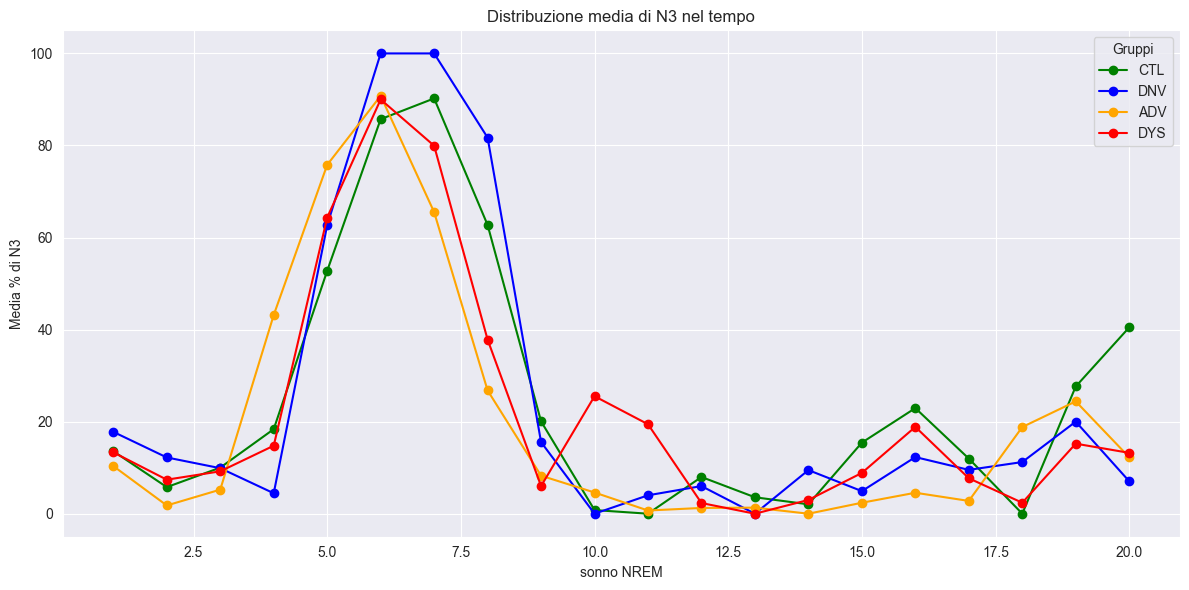

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Gruppi definiti
groups = {
    "CTL": ["PD009", "PD010", "PD020", "PD022", "PD025", "PD033", "PD043"],
    "DNV": ["PD005", "PD013", "PD027", "PD031", "PD041"],
    "ADV": ["PD002", "PD003", "PD007", "PD008", "PD021", "PD028", "PD036", "PD042"],
    "DYS": ["PD012", "PD014", "PD016", "PD017", "PD029", "PD030", "PD035", "PD038", "PD044", "PD045"],
}

n_bins = 20
reference_id = "PD010"

# Usa direttamente i dati allineati (senza DTW qui)
# Supponendo che tu abbia già:
# aligned_stages_dict = {"PD009": np.array([...]), ...}

group_n3_profiles = {group: [] for group in groups}

for group_name, subject_ids in groups.items():
    for subject_id in subject_ids:
        if subject_id not in aligned_stages_dict:
            continue
        aligned = aligned_stages_dict[subject_id]
        aligned = np.round(aligned).astype(int)

        # Isola solo le fasi NREM
        nrem_mask = np.isin(aligned, [1, 2, 3])
        nrem_stages = aligned[nrem_mask]

        if len(nrem_stages) < n_bins:
            continue  # troppo breve

        # Divide il NREM in 10 segmenti
        bin_edges = np.linspace(0, len(nrem_stages), n_bins + 1, dtype=int)
        n3_percentages = []
        for i in range(n_bins):
            segment = nrem_stages[bin_edges[i]:bin_edges[i + 1]]
            if len(segment) == 0:
                n3_percentages.append(0)
            else:
                percent = np.sum(segment == 3) / len(segment) * 100
                n3_percentages.append(percent)

        group_n3_profiles[group_name].append(n3_percentages)

# Media per gruppo
group_n3_means = {
    group: np.mean(profiles, axis=0) if profiles else np.zeros(n_bins)
    for group, profiles in group_n3_profiles.items()
}

# Plot finale
plt.figure(figsize=(12, 6))
colors = {
    "CTL": "green",
    "DNV": "blue",
    "ADV": "orange",
    "DYS": "red"
}

for group, mean_profile in group_n3_means.items():
    plt.plot(range(1, n_bins + 1), mean_profile, label=group, color=colors.get(group, None), marker='o')

plt.title("Distribuzione media di N3 nel tempo")
plt.xlabel("sonno NREM")
plt.ylabel("Media % di N3")
plt.grid(True)
plt.legend(title="Gruppi")
plt.tight_layout()
plt.show()


In [49]:
import numpy as np
from dtw import dtw
from tqdm import tqdm
import pickle

# --- Configurazioni ---
output_file = "aligned_stages_dict.pkl"
min_len = min(len(st) for st in subject_clean_stages.values())  # lunghezza minima comune

# --- Funzione che fa DTW verso tutti gli altri ---
def align_subject_pairwise(subject_id):
    print(f"Elaboro soggetto {subject_id}")
    target_stages = subject_clean_stages[subject_id]
    aligned_versions = []  # Lista per memorizzare tutte le versioni allineate

    for other_id, ref_stages in subject_clean_stages.items():
        if subject_id == other_id:
            continue  # Salta il confronto con se stesso
        _, _, _, path = dtw(ref_stages, target_stages, dist=lambda x, y: abs(x - y))
        indices_ref, indices_target = path
        aligned = np.interp(np.arange(len(ref_stages)), indices_ref, target_stages[indices_target])
        aligned_versions.append(aligned[:min_len])  # Taglia alla lunghezza minima

    return subject_id, aligned_versions

# --- Lista dei soggetti ---
subject_ids = list(subject_clean_stages.keys())

# --- Barra di caricamento con tqdm (per il monitoraggio) ---
results = []
for subject_id in tqdm(subject_ids, desc="Allineamento in corso", unit="soggetto"):
    aligned_subject = align_subject_pairwise(subject_id)
    results.append(aligned_subject)

# --- Crea dizionario finale --- 
aligned_stages_dict = {subject_id: aligned_versions for subject_id, aligned_versions in results}

# --- Salva su file ---
with open(output_file, "wb") as f:
    pickle.dump(aligned_stages_dict, f)

print(f"\n✅ Allineamento completato e salvato in '{output_file}'")


Allineamento in corso:   0%|          | 0/30 [00:00<?, ?soggetto/s]

Elaboro soggetto PD002


Allineamento in corso:   3%|▎         | 1/30 [00:47<22:59, 47.55s/soggetto]

Elaboro soggetto PD003


Allineamento in corso:   7%|▋         | 2/30 [01:35<22:18, 47.82s/soggetto]

Elaboro soggetto PD005


Allineamento in corso:  10%|█         | 3/30 [02:14<19:40, 43.73s/soggetto]

Elaboro soggetto PD007


Allineamento in corso:  13%|█▎        | 4/30 [03:02<19:40, 45.39s/soggetto]

Elaboro soggetto PD008


Allineamento in corso:  17%|█▋        | 5/30 [03:49<19:11, 46.05s/soggetto]

Elaboro soggetto PD009


Allineamento in corso:  20%|██        | 6/30 [04:30<17:45, 44.41s/soggetto]

Elaboro soggetto PD010


Allineamento in corso:  23%|██▎       | 7/30 [05:07<16:00, 41.75s/soggetto]

Elaboro soggetto PD012


Allineamento in corso:  27%|██▋       | 8/30 [05:42<14:37, 39.89s/soggetto]

Elaboro soggetto PD013


Allineamento in corso:  30%|███       | 9/30 [06:21<13:48, 39.44s/soggetto]

Elaboro soggetto PD014


Allineamento in corso:  33%|███▎      | 10/30 [07:03<13:23, 40.17s/soggetto]

Elaboro soggetto PD016


Allineamento in corso:  37%|███▋      | 11/30 [07:41<12:30, 39.48s/soggetto]

Elaboro soggetto PD017


Allineamento in corso:  40%|████      | 12/30 [08:29<12:37, 42.08s/soggetto]

Elaboro soggetto PD020


Allineamento in corso:  43%|████▎     | 13/30 [09:06<11:29, 40.54s/soggetto]

Elaboro soggetto PD021


Allineamento in corso:  47%|████▋     | 14/30 [09:41<10:22, 38.92s/soggetto]

Elaboro soggetto PD022


Allineamento in corso:  50%|█████     | 15/30 [10:20<09:46, 39.08s/soggetto]

Elaboro soggetto PD025


Allineamento in corso:  53%|█████▎    | 16/30 [10:51<08:30, 36.49s/soggetto]

Elaboro soggetto PD027


Allineamento in corso:  57%|█████▋    | 17/30 [11:54<09:39, 44.57s/soggetto]

Elaboro soggetto PD028


Allineamento in corso:  60%|██████    | 18/30 [12:44<09:13, 46.15s/soggetto]

Elaboro soggetto PD029


Allineamento in corso:  63%|██████▎   | 19/30 [13:26<08:14, 45.00s/soggetto]

Elaboro soggetto PD030


Allineamento in corso:  67%|██████▋   | 20/30 [14:00<06:57, 41.75s/soggetto]

Elaboro soggetto PD031


Allineamento in corso:  70%|███████   | 21/30 [14:38<06:04, 40.45s/soggetto]

Elaboro soggetto PD033


Allineamento in corso:  73%|███████▎  | 22/30 [15:12<05:09, 38.65s/soggetto]

Elaboro soggetto PD035


Allineamento in corso:  77%|███████▋  | 23/30 [15:54<04:36, 39.44s/soggetto]

Elaboro soggetto PD036


Allineamento in corso:  80%|████████  | 24/30 [16:38<04:05, 40.93s/soggetto]

Elaboro soggetto PD038


Allineamento in corso:  83%|████████▎ | 25/30 [17:13<03:16, 39.28s/soggetto]

Elaboro soggetto PD041


Allineamento in corso:  87%|████████▋ | 26/30 [17:53<02:37, 39.44s/soggetto]

Elaboro soggetto PD042


Allineamento in corso:  90%|█████████ | 27/30 [18:38<02:03, 41.10s/soggetto]

Elaboro soggetto PD043


Allineamento in corso:  93%|█████████▎| 28/30 [19:20<01:22, 41.15s/soggetto]

Elaboro soggetto PD044


Allineamento in corso:  97%|█████████▋| 29/30 [20:04<00:42, 42.25s/soggetto]

Elaboro soggetto PD045


Allineamento in corso: 100%|██████████| 30/30 [20:36<00:00, 41.23s/soggetto]


✅ Allineamento completato e salvato in 'C:\Users\Lorenzo\Desktop\aligned_stages_dict.pkl'


In [65]:
import pickle

with open("aligned_stages_dict.pkl", "rb") as f:
    aligned_stages_dict = pickle.load(f)
